***1. Модель для динамического ценообразования***

Клиенту требуется набрать в проект людей как можно быстрее, при этом точно знать что рабочие выйдут на объект.

Один из параметров на которые клиент влияет - это цена  задания. Но клиент не знает структуру рынка труда для данной специальности (например, сколько в данном районе получают штукуатуры за смены или электрики), и может поставить цену непривлекательную для исполнителя или наоборот слишком высокую, что приведет к перерасходу бюджета.
Наша модель машинного обучения предложит клиенту в момент создания проекта и заказа оптимальную цену.


Для этого по историческим данным собран датасет с такими данными как:
- Тип работы 
- Продолжительнсть заказа
- Город 
- Расстояние от центра города
- Тип работы
- Продолжительность заказа (часы)
- Рейтинг клиента среди исполнителей
- Требуемая квалификация (уровень)
- Сезонность (месец)
- День недели
- Время суток
- Наличие бонусов (да/нет)
- Средняя температура на дату заказа (градусы)
- Количество доступных работников в данном районе
- Историческая средняя цена за подобные работы
- Уровень безработицы в данном районе
- Средний рейтинг исполнителей

Целевым признаком в данной модели будет время самодобавления человека в смену, мы  стараемся его минимизировать.
При помощи кросс валидации находим валидируем качество модели


In [5]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [13]:
# Скрыть предупреждения
warnings.filterwarnings('ignore')

# получение анныех
data = pd.read_csv('dynamic_pricisin_dataset.csv.csv')

# Преобразование категориальных признаков в числовые
data = pd.get_dummies(data, columns=['тип_работы', 'город', 'требуемая_квалификация'], drop_first=True)

# Определение признаков и целевой переменной
X = data.drop('время_самодобавления', axis=1)
y = data['время_самодобавления']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Построение модели случайного леса
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование и оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка: {mse:.2f}')

# Функция для поиска оптимальной цены
def find_optimal_price(model, new_job, price_range):
    min_time = float('inf')
    best_price = None
    
    for price in price_range:
        new_job['цена_за_смену'] = price
        new_job_scaled = scaler.transform(new_job)
        predicted_time = model.predict(new_job_scaled)
        if predicted_time < min_time:
            min_time = predicted_time
            best_price = price
            
    return best_price, min_time

# Прогнозирование времени самодобавления для нового заказа
new_job = pd.DataFrame({
    'продолжительность_заказа': [8],
    'расстояние_от_центра': [5],
    'сезон': [7],
    'день_недели': [3],
    'время_суток': [14],
    'наличие_бонусов': [1],
    'средняя_температура': [20],
    'количество_доступных_работников': [25],
    'историческая_средняя_цена': [3000],
    'уровень_безработицы': [3.5],
    'средний_рейтинг': [4.2],
    'тип_работы_покраска': [0],
    'тип_работы_уборка': [0],
    'тип_работы_электрика': [0],
    'город_Санкт-Петербург': [0],
    'город_Новосибирск': [0],
    'город_Екатеринбург': [0],
    'требуемая_квалификация_средняя': [1],
    'требуемая_квалификация_высокая': [0]
})

# Заполнение отсутствующих столбцов нулями
missing_cols = set(X.columns) - set(new_job.columns)
for col in missing_cols:
    new_job[col] = 0
new_job = new_job[X.columns]

# Определение диапазона цен для поиска оптимального значения
price_range = np.linspace(1950, 10000, 100)

# Поиск оптимальной цены
optimal_price, minimal_time = find_optimal_price(model, new_job, price_range)
print(f"Рекомендованная цена за смену: {optimal_price:.2f} руб., ожидаемое время самодобавления исполнителя в проект: {minimal_time[0]:.2f} часов.")

Среднеквадратичная ошибка: 2.01
Рекомендованная цена за смену: 1950.00 руб., ожидаемое время самодобавления исполнителя в проект: 2.09 часов.


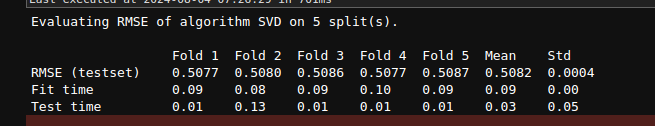

***2. Модель прогнозирования вероятности выхода на смену исполнителя***


Клиент хочет быть уверен что заказ будет выполнен исполнителями качественно и в срок. При этом у исполнитель может не выйти на заказ, или иным образом повлиять на качество и время выполнения заказа. Помимо очевидной метрики "рейтинг исполнителя от клиента" мы хотим предсказать процент вероятности выхода исполнителя на смену, чтобы принимающий решение человек мог либо набрать резервных исполнителей либо убрать тех у кого процент низок.

Для этого по историческим данным собран датасет с такими данными как:

- ID заказа
- ID исполнителя
- Тип работы
- Город
- Продолжительность заказа
- Расстояние от центра города
- Рейтинг исполнителя
- Возраст исполнителя
- Опыт работы исполнителя (в годах)
- Наличие бонусов
- Историческая средняя зарплата за смену в этом районе
- Уровень безработицы в регионе
- День недели
- Время суток
- СезонID заказа
- ID исполнителя
- Тип работы
- Город
- Продолжительность заказа
- Расстояние от центра города
- Рейтинг исполнителя
- Возраст исполнителя
- Опыт работы исполнителя (в годах)
- Наличие бонусов
- Историческая средняя зарплата за смену в этом районе
- Уровень безработицы в регионе
- День недели
- Время суток
- Сезон






Целевым признаком в данной модели будет бинарный признак вышел/не вышел на смену




In [16]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [17]:
# Чтение данных из CSV
data = pd.read_csv('dataset_vykhod_na_smjenu.csv')

# Преобразование категориальных признаков в числовые
data = pd.get_dummies(data, columns=['тип_работы', 'город'], drop_first=True)

# Определение признаков и целевой переменной
X = data.drop('вышел_на_смену', axis=1)
y = data['вышел_на_смену']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Построение модели случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование и оценка модели
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy:.2f}')

# Прогнозирование вероятности выхода на смену для нового заказа
new_job = pd.DataFrame({
    'ID_заказа': [10001],
    'ID_исполнителя': [501],
    'продолжительность_заказа': [8],
    'расстояние_от_центра': [5],
    'рейтинг_исполнителя': [4.2],
    'возраст_исполнителя': [30],
    'опыт_работы': [5],
    'наличие_бонусов': [1],
    'историческая_средняя_зарплата': [3000],
    'уровень_безработицы': [3.5],
    'день_недели': [3],
    'время_суток': [14],
    'сезон': [2],
    'тип_работы_покраска': [0],
    'тип_работы_уборка': [0],
    'тип_работы_электрика': [0],
    'город_Санкт-Петербург': [0],
    'город_Новосибирск': [0],
    'город_Екатеринбург': [0]
})

# Заполнение отсутствующих столбцов нулями
missing_cols = set(X.columns) - set(new_job.columns)
for col in missing_cols:
    new_job[col] = 0
new_job = new_job[X.columns]

# Масштабирование новых данных
new_job_scaled = scaler.transform(new_job)

# Прогнозирование вероятности
probability = model.predict_proba(new_job_scaled)[0, 1]
print(f"Вероятность выхода на смену: {probability:.2f}")

Точность модели: 0.49
Вероятность выхода на смену: 0.47


***3.Рекомендация заявок***

Исполнителю может быть доступно для выполнения работ множество заказов. При этом ему было бы проще не выбирать каждый раз и получать рекомендацию на основании его прошлых выборов.


Признаки данных
- ID заказа
- ID исполнителя
- Тип работы
- Город
- Продолжительность заказа
- Расстояние от центра города
- Рейтинг исполнителя
- Возраст исполнителя
- Опыт работы исполнителя (в годах)
- Наличие бонусов
- Историческая средняя зарплата за смену в этом районе
- Уровень безработицы в регионе
- День недели
- Время суток
- СезонПризнаки данных
- ID заказа
- ID исполнителя
- Тип работы
- Город
- Продолжительность заказа
- Расстояние от центра города
- Рейтинг исполнителя
- Возраст исполнителя
- Опыт работы исполнителя (в годах)
- Наличие бонусов
- Историческая средняя зарплата за смену в этом районе
- Уровень безработицы в регионе
- День недели
- Время суток
- Сезон


Данная модель работает на основе коллаборативной фильтрации


In [18]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
# Скрыть предупреждения
warnings.filterwarnings('ignore')

In [33]:
!pip install surprise

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 782.2 kB/s eta 0:00:001m707.2 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357246 sha256=72567153b606a7fe6a652a298ec586a88cf36e43d5e94336795392c3b32c9848
  Stored in directory: /home/nikita/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [36]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Скрыть предупреждения
import warnings
warnings.filterwarnings('ignore')

# Генерация примерных данных
np.random.seed(42)

# Чтение данных из CSV
data = pd.read_csv('dataset_recommendations.csv')

# Создание коллаборативной модели
reader = Reader(rating_scale=(0, 1))
dataset = Dataset.load_from_df(data[['ID_исполнителя', 'ID_заказа', 'выбран_заказ']], reader)
trainset, testset = train_test_split(dataset, test_size=0.2)

# Использование SVD модели для коллаборативной фильтрации
model = SVD()
model.fit(trainset)

# Оценка модели
predictions = model.test(testset)
print(f'RMSE: {rmse(predictions):.2f}')


RMSE: 0.5094
RMSE: 0.51


In [42]:
def recommend_job_for_worker(model, worker_id, available_jobs, n_recommendations=1):
    """
    Рекомендовать заказы для конкретного исполнителя.

    :param model: Обученная модель коллаборативной фильтрации.
    :param worker_id: ID исполнителя для рекомендации.
    :param available_jobs: DataFrame с доступными заказами.
    :param n_recommendations: Количество рекомендаций.
    :return: DataFrame с рекомендованными заказами.
    """
    # Прогнозирование оценки для каждого заказа
    available_jobs['predicted_score'] = available_jobs['ID_заказа'].apply(lambda x: model.predict(worker_id, x).est)
    
    # Выбор top_n заказов с наивысшим прогнозируемым баллом
    recommended_jobs = available_jobs.sort_values('predicted_score', ascending=False).head(n_recommendations)
    
    # Возвращение только нужных столбцов
    return recommended_jobs[['ID_заказа', 'тип_работы', 'город']]

# Пример списка доступных заказов для рекомендации
available_jobs = pd.DataFrame({
    'ID_заказа': [10002, 10003, 10004, 10005, 10006],
    'тип_работы': ['покраска', 'штукатурка', 'электрика', 'уборка', 'покраска'],
    'город': ['Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Москва']
})

# Рекомендация одного заказа для исполнителя с ID 501
worker_id = 501
recommended_job = recommend_job_for_worker(model, worker_id, available_jobs, n_recommendations=1)
print('Вам рекомендован заказ:',recommended_job)


Вам рекомендован заказ:    ID_заказа тип_работы   город
0      10002   покраска  Москва
